### 1. Импорты

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

#### 1.1 Настройка стиля графиков

In [69]:
sns.set_style('whitegrid')
%matplotlib inline

### 2. Загрузка данных

In [70]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')

Для удобства сохраним отдельно PassengerId (может понадобиться для сабмишна)

In [71]:
passenger_ids = df['PassengerId']

In [72]:
print("Размер данных:", df.shape)
df.head()

Размер данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3. Анализ данных

In [73]:
df.info()

print("\nСтатистика числовых признаков:")
df.describe()

print("\nПропуски в данных:")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Статистика числовых признаков:

Пропуски в данных:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### 3.1 Визуализация пропусков

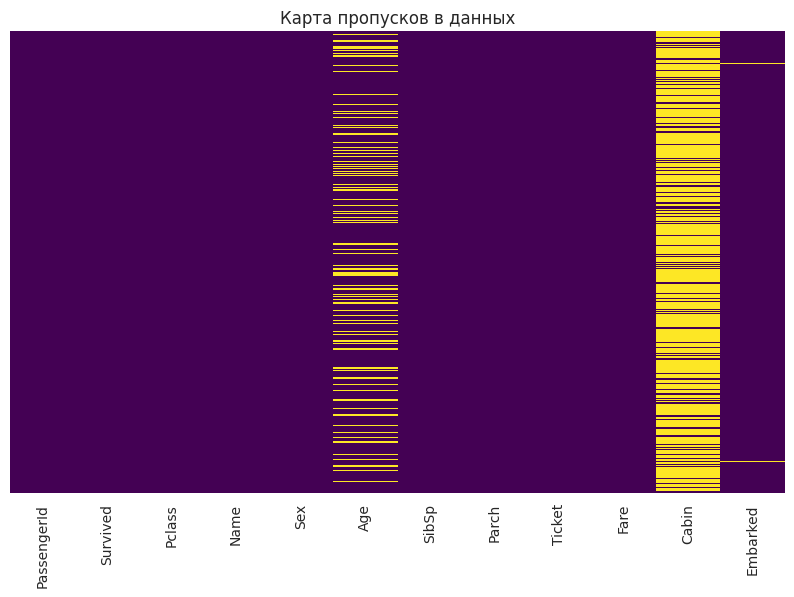

In [74]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Карта пропусков в данных')
plt.show()

#### 3.2 Анализ целевой переменной Survived

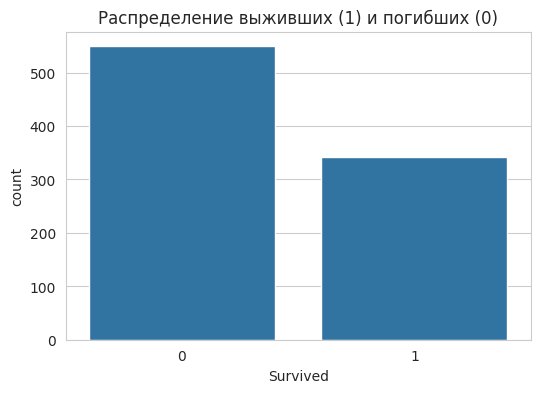

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [75]:
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=df)
plt.title('Распределение выживших (1) и погибших (0)')
plt.show()

print(df['Survived'].value_counts(normalize=True))

#### 3.3 Анализ признаков

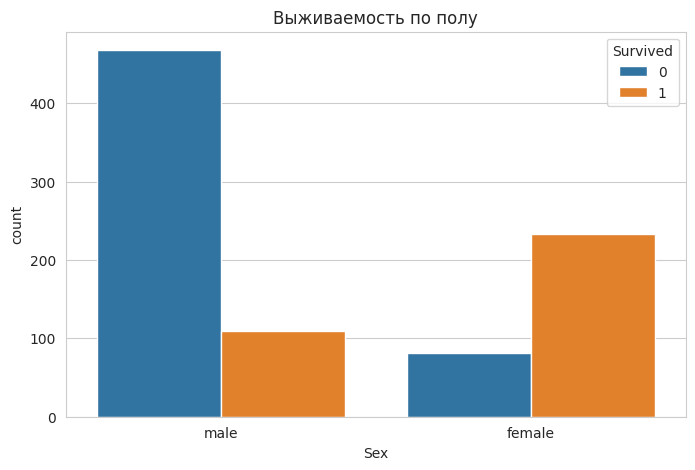

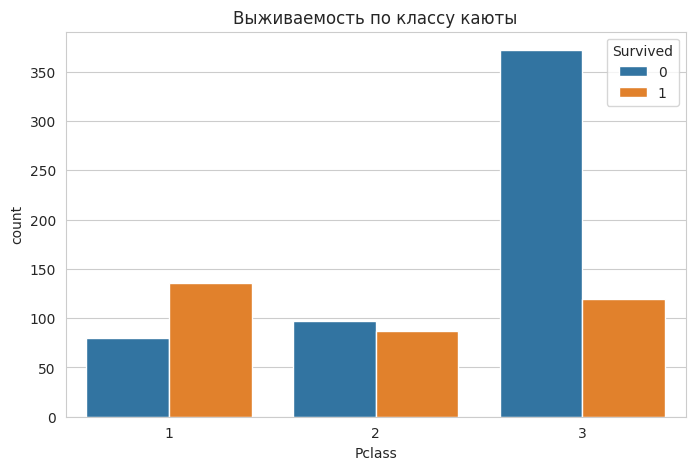

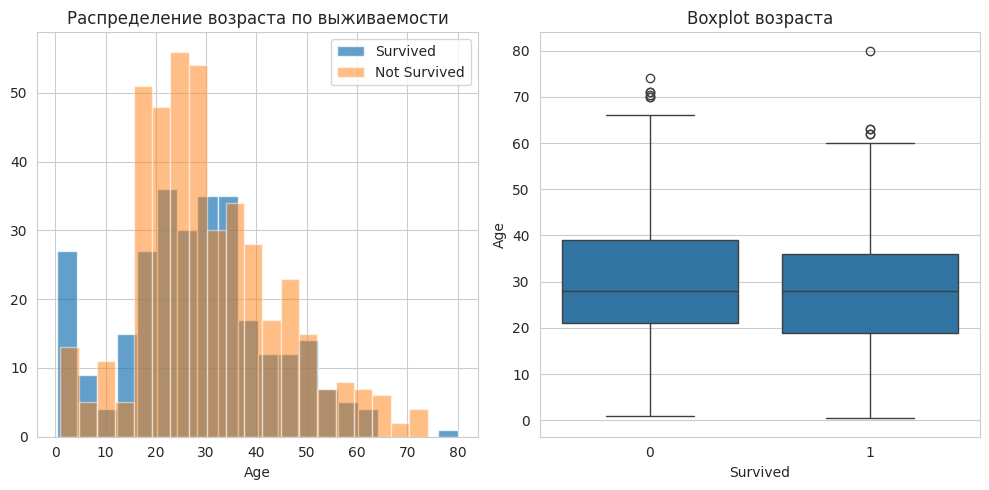

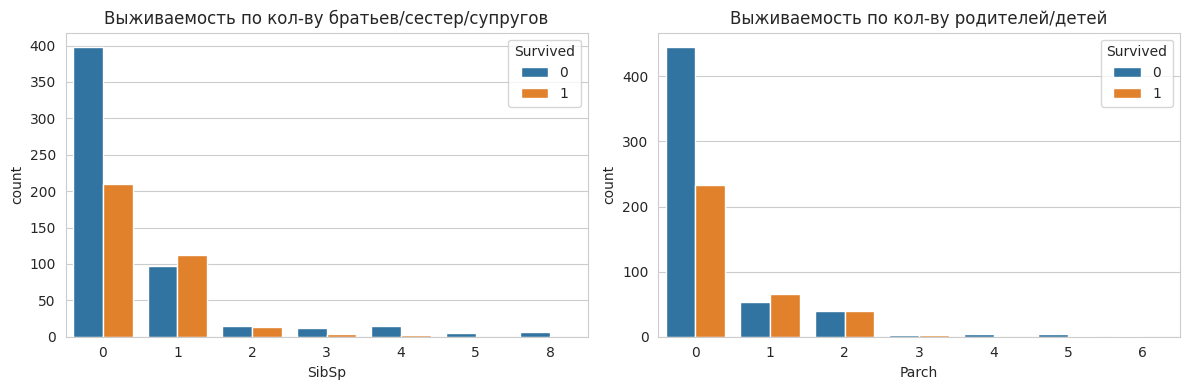

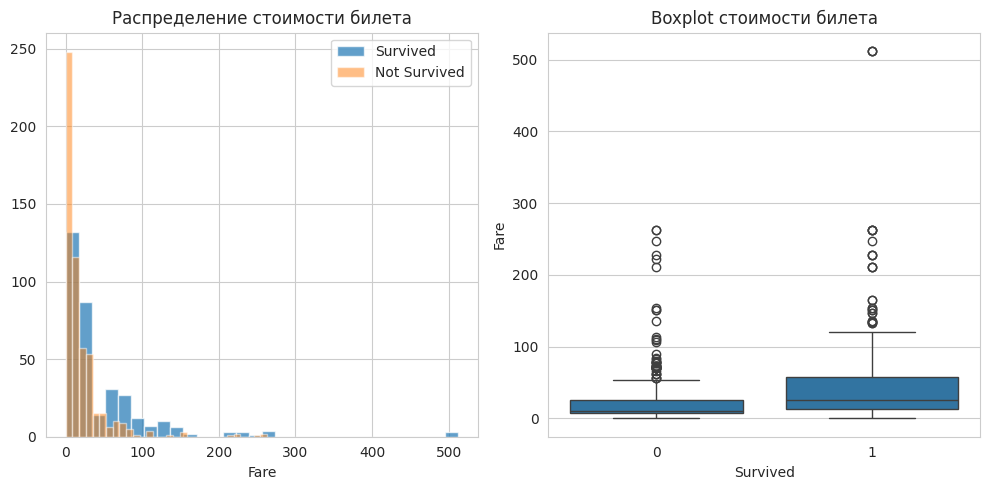

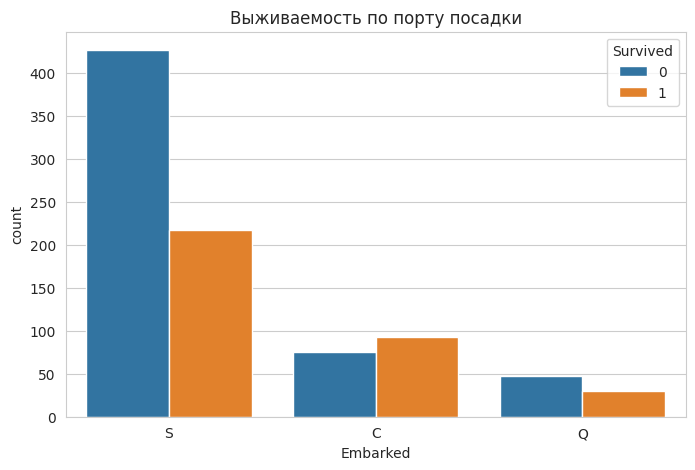

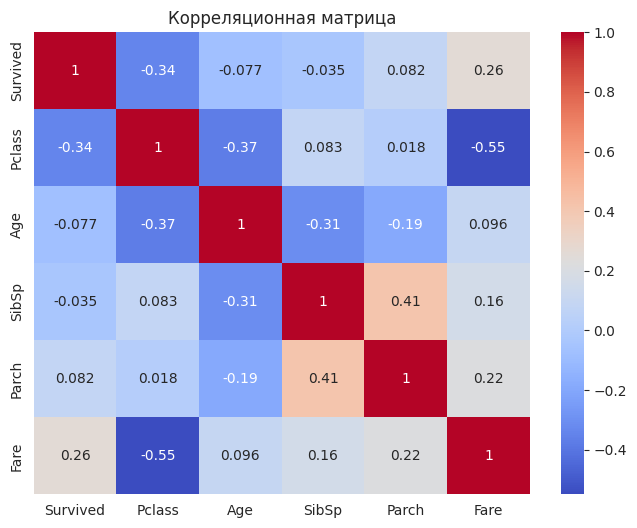

In [76]:
# Пол
plt.figure(figsize=(8,5))
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Выживаемость по полу')
plt.show()

# Класс каюты
plt.figure(figsize=(8,5))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Выживаемость по классу каюты')
plt.show()

# Возраст
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
df[df['Survived']==1]['Age'].hist(alpha=0.7, label='Survived', bins=20)
df[df['Survived']==0]['Age'].hist(alpha=0.5, label='Not Survived', bins=20)
plt.legend()
plt.xlabel('Age')
plt.title('Распределение возраста по выживаемости')

plt.subplot(1,2,2)
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Boxplot возраста')
plt.tight_layout()
plt.show()

# Семейные признаки
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.countplot(x='SibSp', hue='Survived', data=df, ax=axes[0])
axes[0].set_title('Выживаемость по кол-ву братьев/сестер/супругов')
sns.countplot(x='Parch', hue='Survived', data=df, ax=axes[1])
axes[1].set_title('Выживаемость по кол-ву родителей/детей')
plt.tight_layout()
plt.show()

# Стоимость билета
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
df[df['Survived']==1]['Fare'].hist(alpha=0.7, label='Survived', bins=30)
df[df['Survived']==0]['Fare'].hist(alpha=0.5, label='Not Survived', bins=30)
plt.legend()
plt.xlabel('Fare')
plt.title('Распределение стоимости билета')

plt.subplot(1,2,2)
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Boxplot стоимости билета')
plt.tight_layout()
plt.show()

# Порт посадки
plt.figure(figsize=(8,5))
sns.countplot(x='Embarked', hue='Survived', data=df)
plt.title('Выживаемость по порту посадки')
plt.show()

# Корреляционная матрица числовых признаков
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

### 4. Создание новых признаков

In [77]:
# Копируем данные, чтобы не изменять оригинал
data = df.copy()

# Извлечение титула из имени
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Объединим редкие титулы в категорию Rare
title_counts = data['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index.tolist()
data['Title'] = data['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)

# Размер семьи
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# Одинок ли пассажир
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# Извлечение палубы из кабин
data['Deck'] = data['Cabin'].str[0]  # первая буква каюты
data['Deck'] = data['Deck'].fillna('U')  # неизвестные каюты обозначим как 'U'

Посмотрим на созданные признаки

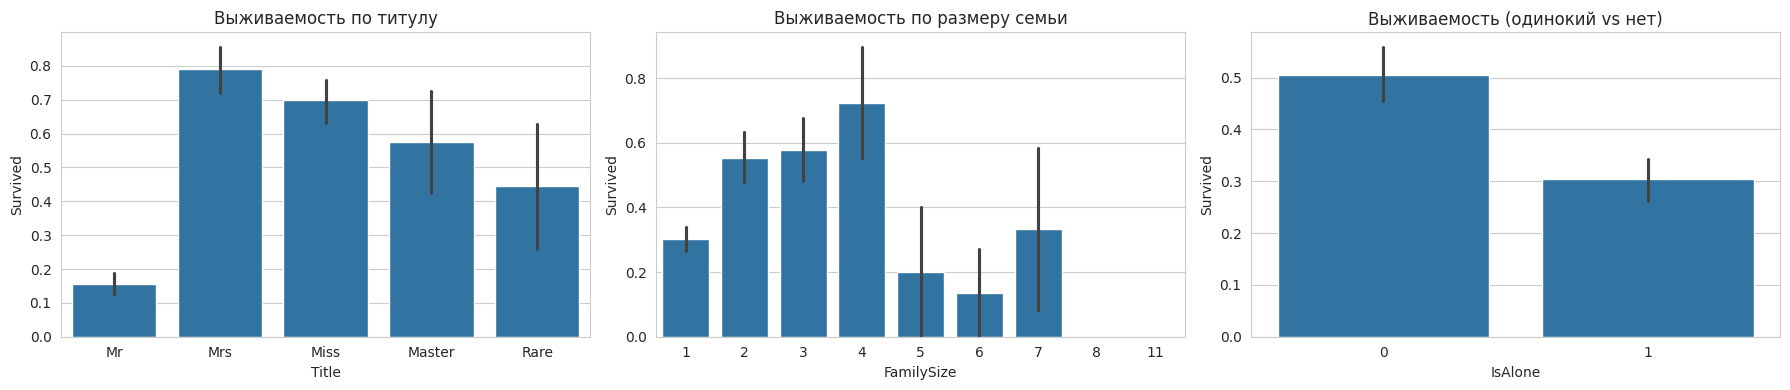

In [78]:
data[['Title', 'FamilySize', 'IsAlone', 'Deck']].head(10)

fig, axes = plt.subplots(1,3, figsize=(18,4))

sns.barplot(x='Title', y='Survived', data=data, ax=axes[0])
axes[0].set_title('Выживаемость по титулу')

sns.barplot(x='FamilySize', y='Survived', data=data, ax=axes[1])
axes[1].set_title('Выживаемость по размеру семьи')

sns.barplot(x='IsAlone', y='Survived', data=data, ax=axes[2])
axes[2].set_title('Выживаемость (одинокий vs нет)')
plt.tight_layout()
plt.show()

### 5. Обработка пропусков

In [79]:
print("Пропуски после создания признаков:")
print(data.isnull().sum())

Пропуски после создания признаков:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
FamilySize       0
IsAlone          0
Deck             0
dtype: int64


Возраст заполним медианой по группе (Pclass, Sex)

In [80]:
def fill_age(df):
    median_age = df.groupby(['Pclass', 'Sex'])['Age'].transform('median')
    df['Age'] = df['Age'].fillna(median_age)
    return df

data = fill_age(data)

Порт посадки (Embarked) заполним модой

In [81]:
mode_embarked = data['Embarked'].mode()[0]
data['Embarked'] = data['Embarked'].fillna(mode_embarked)

Стоимость билета (Fare) на всякий случай заполним медианой

In [82]:
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

Проверим, что пропусков больше нет

In [83]:
print("\nПропуски после заполнения:")
print(data.isnull().sum())


Пропуски после заполнения:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
FamilySize       0
IsAlone          0
Deck             0
dtype: int64


### 6. Кодирование категориальных признаков

#### 6.1 Выберем признаки для модели (исключим ненужные)

PassengerId, Name, Ticket, Cabin (исходный) удалим

In [84]:
features = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis=1)
target = data['Survived']

Посмотрим на типы признаков

In [85]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    object 
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked    891 non-null    object 
 7   Title       891 non-null    object 
 8   FamilySize  891 non-null    int64  
 9   IsAlone     891 non-null    int64  
 10  Deck        891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


#### 6.2 Разделим признаки на числовые и категориальные

In [86]:
numeric_features = ['Age', 'Fare', 'FamilySize']

In [87]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'IsAlone']

IsAlone - бинарный, но можно оставить как категорию

In [88]:
features['IsAlone'] = features['IsAlone'].astype(int)

Pclass можно оставить как число, но для единообразия включим в категориальные

#### 6.3 Создадим препроцессор для числовых и категориальных признаков

Для числовых - масштабирование (StandardScaler)

Для категориальных - one-hot encoding (кроме тех, что имеют порядок, но тут все номинальные)

In [89]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X = features
y = target

#### 6.4 Разделим на обучающую и валидационную выборки

In [90]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер обучающей выборки: (712, 11)
Размер валидационной выборки: (179, 11)


### 7. Обучение базовых моделей и сравнение

Создадим словарь моделей

In [91]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

Для каждой модели создадим пайплайн с препроцессором и оценим с помощью кросс-валидации

In [92]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    results[name] = {'mean': scores.mean(), 'std': scores.std()}
    print(f"{name}: Accuracy = {scores.mean():.4f} (+/- {scores.std():.4f})")

Logistic Regression: Accuracy = 0.8259 (+/- 0.0239)
SVM: Accuracy = 0.8244 (+/- 0.0205)
Decision Tree: Accuracy = 0.7809 (+/- 0.0187)
Random Forest: Accuracy = 0.8034 (+/- 0.0190)
Gradient Boosting: Accuracy = 0.8188 (+/- 0.0255)
KNN: Accuracy = 0.8062 (+/- 0.0281)


Визуализируем результаты

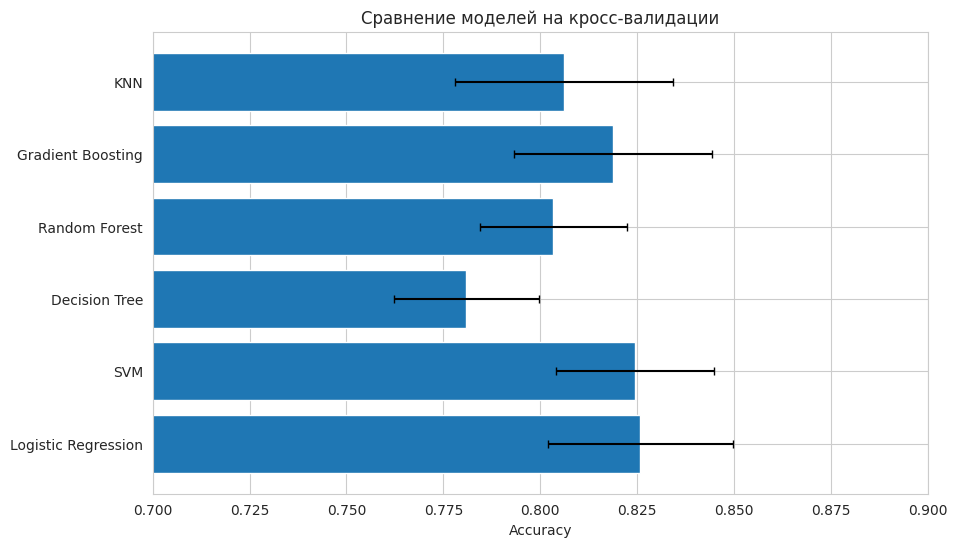

In [93]:
plt.figure(figsize=(10,6))
model_names = list(results.keys())
means = [results[m]['mean'] for m in model_names]
stds = [results[m]['std'] for m in model_names]
plt.barh(model_names, means, xerr=stds, capsize=3)
plt.xlabel('Accuracy')
plt.title('Сравнение моделей на кросс-валидации')
plt.xlim(0.7, 0.9)
plt.show()

### 8. Настройка гиперпараметров для лучших моделей

По результатам лучшие: Logistic Regression, SVM, Gradient Boosting, Random Forest. Выполним GridSearch для Gradient Boosting.

Сначала создадим пайплайн с препроцессором для удобства

In [94]:
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42))])

Зададим сетку параметров

In [95]:
param_grid_gb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__min_samples_split': [2, 5]
}

grid_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_gb.fit(X_train, y_train)

print("Лучшие параметры для Gradient Boosting:")
print(grid_gb.best_params_)
print("Лучшая accuracy на кросс-валидации: {:.4f}".format(grid_gb.best_score_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Лучшие параметры для Gradient Boosting:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Лучшая accuracy на кросс-валидации: 0.8315


Аналогично для Random Forest

In [96]:
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("\nЛучшие параметры для Random Forest:")
print(grid_rf.best_params_)
print("Лучшая accuracy на кросс-валидации: {:.4f}".format(grid_rf.best_score_))

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Лучшие параметры для Random Forest:
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Лучшая accuracy на кросс-валидации: 0.8301


Для SVM

In [97]:
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', SVC(random_state=42, probability=True))])

param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.1],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid']
}

grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_svm.fit(X_train, y_train)

print("\nЛучшие параметры для SVM:")
print(grid_svm.best_params_)
print("Лучшая accuracy на кросс-валидации: {:.4f}".format(grid_svm.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Лучшие параметры для SVM:
{'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Лучшая accuracy на кросс-валидации: 0.8315


In [98]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])

param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'],
    'classifier__max_iter': [1000, 2000, 3000],
    'classifier__class_weight': [None, 'balanced']
}

param_grid_lr_v2 = [
    {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2', None],
        'classifier__solver': ['lbfgs', 'newton-cg'],
        'classifier__max_iter': [1000],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear'],
        'classifier__max_iter': [1000],
        'classifier__class_weight': [None, 'balanced']
    }
]

param_grid_lr_simple = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs'],
    'classifier__class_weight': [None, 'balanced']
}

grid_lr = GridSearchCV(pipeline_lr, param_grid_lr_simple, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)

print("\nЛучшие параметры для LR:")
for param, value in grid_lr.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nЛучшая accuracy на кросс-валидации: {grid_lr.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Лучшие параметры для LR:
  classifier__C: 0.1
  classifier__class_weight: None
  classifier__penalty: l2
  classifier__solver: lbfgs

Лучшая accuracy на кросс-валидации: 0.8217


Выберем лучшую модель среди настроенных

In [99]:
best_models = {
    'Gradient Boosting (tuned)': grid_gb.best_estimator_,
    'Random Forest (tuned)': grid_rf.best_estimator_,
    'SVM (tuned)': grid_svm.best_estimator_,
    'LR (tuned)': grid_lr.best_estimator_
}

Оценим их на валидационной выборке

In [100]:
for name, model in best_models.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} - Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred, target_names=['Not Survived', 'Survived']))
    print("-"*60)

Gradient Boosting (tuned) - Validation Accuracy: 0.8268
              precision    recall  f1-score   support

Not Survived       0.83      0.91      0.87       110
    Survived       0.83      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179

------------------------------------------------------------
Random Forest (tuned) - Validation Accuracy: 0.7933
              precision    recall  f1-score   support

Not Survived       0.80      0.88      0.84       110
    Survived       0.78      0.65      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179

------------------------------------------------------------
SVM (tuned) - Validation Accuracy: 0.7765
              precision    recall  f1-score   support

Not Survived       

Возьмем Gradient Boosting как финальную модель.

In [101]:
final_model = grid_gb.best_estimator_

### 9. Интерпретация важности признаков

Из-за препроцессора имена признаков могут быть изменены, чтобы понять важность, можно получить имена после one-hot encoding.


Получим названия признаков после трансформации. Для этого обучим препроцессор на всех данных и посмотрим названия.

In [102]:
preprocessor_fitted = preprocessor.fit(X_train)

Получим названия категориальных признаков после one-hot

In [103]:
cat_feature_names = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

Важность признаков из модели GradientBoostingClassifier

In [104]:
importances = final_model.named_steps['classifier'].feature_importances_

Создадим DataFrame для визуализации

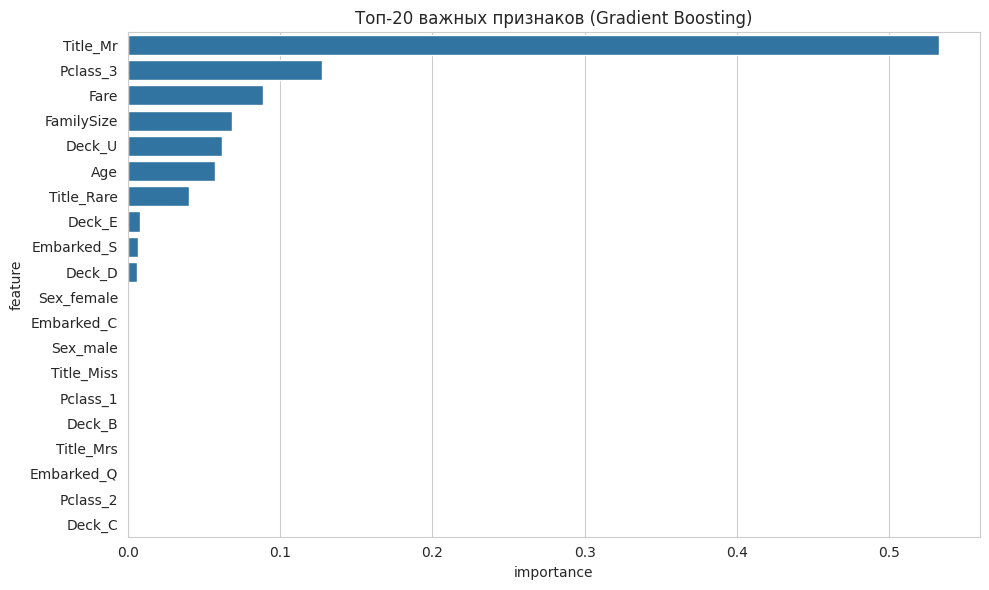

In [105]:
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('Топ-20 важных признаков (Gradient Boosting)')
plt.tight_layout()
plt.show()

### 10. Kaggle Submission

Загружаем test.csv

In [106]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
test_ids = test_df['PassengerId']

Копируем данные

In [107]:
test_data = test_df.copy()

Feature Engineering

In [108]:
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)

test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

test_data['Deck'] = test_data['Cabin'].str[0]
test_data['Deck'] = test_data['Deck'].fillna('U')

Заполнение пропусков

In [109]:
test_data = fill_age(test_data)

test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())
test_data['Embarked'] = test_data['Embarked'].fillna(mode_embarked)

Берём только те признаки, что использовались в обучении

In [110]:
test_features = test_data[X.columns]

Предсказание через pipeline

In [111]:
test_pred = final_model.predict(test_features)

Создаем submission

In [112]:
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Survived': test_pred
})

submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
